In [1]:
import kagglehub

In [2]:
# Download Dataset
data_dir = kagglehub.dataset_download('andrewmvd/dog-and-cat-detection')
print(f"Path to Dataset: {data_dir}")

Path to Dataset: /kaggle/input/dog-and-cat-detection


In [3]:
!pip install torchmetrics
!pip install pycocotools

In [4]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet50_Weights
import torch.nn.functional as F
import random

# Data Visualizer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Data Reader
import xml.etree.ElementTree as ET

import time

----------------

# **Sample Data**

In [5]:
sample_annotation = '/kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml'
sample_tree = ET.parse(sample_annotation)
sample_root = sample_tree.getroot()

for element in sample_root:
    print(f"{element} is an element in {sample_annotation}")

folder_tag = sample_root.findall('folder')
filename_tag = sample_root.findall('filename')
size_tag = sample_root.findall('size')
segmented_tag = sample_root.findall('segmented')
object_tag = sample_root.findall('object')
print("-"*59)
print(f"Type of folder_tag is: {type(folder_tag)}")
print(f"Type of filename_tag is: {type(filename_tag)}")
print(f"Type of size_tag is: {type(size_tag)}")
print(f"Type of segmented_tag is: {type(segmented_tag)}")
print(f"Type of object_tag is: {type(object_tag)}")

<Element 'folder' at 0x79be4535f970> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'filename' at 0x79be4535f9c0> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'size' at 0x79be4535fa10> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'segmented' at 0x79be4535fb50> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'object' at 0x79be4535fba0> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
-----------------------------------------------------------
Type of folder_tag is: <class 'list'>
Type of filename_tag is: <class 'list'>
Type of size_tag is: <class 'list'>
Type of segmented_tag is: <class 'list'>
Type of object_tag is: <class 'list'>


In [6]:
for element in folder_tag[0]:
    print(f"{element} is an element in folder_tag")
print("-"*59)

for element in filename_tag[0]:
    print(f"{element} is an element in filename_tag")
print("-"*59)

for element in size_tag[0]:
    print(f"{element} is an element in size_tag")
print("-"*59)

for i in segmented_tag[0]:
    print(f"{element} is an element in segmented_tag")
print("-"*59)

for element in object_tag[0]:
    print(f"{element} is an element in object_tag")

-----------------------------------------------------------
-----------------------------------------------------------
<Element 'width' at 0x79be4535fa60> is an element in size_tag
<Element 'height' at 0x79be4535fab0> is an element in size_tag
<Element 'depth' at 0x79be4535fb00> is an element in size_tag
-----------------------------------------------------------
-----------------------------------------------------------
<Element 'name' at 0x79be4535fbf0> is an element in object_tag
<Element 'pose' at 0x79be4535fc40> is an element in object_tag
<Element 'truncated' at 0x79be4535fc90> is an element in object_tag
<Element 'occluded' at 0x79be4535fce0> is an element in object_tag
<Element 'difficult' at 0x79be4535fd30> is an element in object_tag
<Element 'bndbox' at 0x79be4535fd80> is an element in object_tag


In [7]:
for element in object_tag[0][5]:
    print(f"{element} is an element in object_tag")

<Element 'xmin' at 0x79be4535fdd0> is an element in object_tag
<Element 'ymin' at 0x79be4535fe20> is an element in object_tag
<Element 'xmax' at 0x79be4535fe70> is an element in object_tag
<Element 'ymax' at 0x79be4535fec0> is an element in object_tag


In [8]:
print(object_tag[0][0].text)
print(type(object_tag[0][0].text))

cat
<class 'str'>


In [9]:
print(object_tag[0][5])
print(object_tag[0][5].findall('xmin')[0].text)

<Element 'bndbox' at 0x79be4535fd80>
83


In [10]:
print(size_tag[0][0].text)
print(size_tag[0][1].text)

233
350


# Tree Structure
```
<annotation>
    <folder>images</folder>
    <filename>Cats_Test0.png</filename>
    <size>
        <width>233</width>
        <height>350</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>83</xmin>
            <ymin>29</ymin>
            <xmax>197</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
</annotation>

----------------

# **Dataset**

In [11]:
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform = None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()


    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for image in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, image)):
                img_name = image
                annotation_name = os.path.splitext(img_name)[0] + '.xml'
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count

        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        size_tag = root.findall('size')

        # Get Image's Height n' Width for Normalization
        image_width = int(size_tag[0][0].text)
        image_height = int(size_tag[0][1].text)
        
        # Loop through all Objects in Annotations
        label = None
        bbox = None
        for obj_tag in root.findall('object'):
            name = obj_tag.find("name").text # String
            if label is None: # Take Only The First label
                label = name

                # Bounding Box Coords
                xmin = int(obj_tag.find('bndbox/xmin').text)
                ymin = int(obj_tag.find('bndbox/ymin').text)
                xmax = int(obj_tag.find('bndbox/xmax').text)
                ymax = int(obj_tag.find('bndbox/ymax').text)

                bbox = [
                    xmin/image_width,
                    ymin/image_height,
                    xmax/image_width,
                    ymax/image_height
                ]
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1
        return label_num, torch.tensor(bbox, dtype = torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # First Image
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)

        annotation_name = os.path.splitext(img1_file)[0] + '.xml'
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )
        
        # Second Image
        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)

        annotation_name = os.path.splitext(img2_file)[0] + '.xml'
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        # Open the 2 Images
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        # Horizontal Merge
        merged_img = Image.new(
            'RGB', (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_img.paste(img1, (0, 0))
        merged_img.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)
        merged_annotations = []

        # Adjust bbox coordinates for objects from img1 AND normalize
        new_bbox1 = [
            img1_annotations[1][0] * img1.width / merged_w,  # Normalize xmin
            img1_annotations[1][1] * img1.height / merged_h,  # Normalize ymin
            img1_annotations[1][2] * img1.width / merged_w,  # Normalize xmax
            img1_annotations[1][3] * img1.height / merged_h,  # Normalize ymax
        ]
        merged_annotations.append({"bbox": new_bbox1, "label": img1_annotations[0]})

        new_bbox = [
            # Normalize xmin
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,
        
            # Normalized ymin
            img2_annotations[1][1] * img2.height/merged_h,
        
            # Normalized xmax
             (img2_annotations[1][2] * img2.width + img1.width) / merged_w,
        
            # Normalized ymax
             img2_annotations[1][3] * img2.height / merged_h
        ]
        merged_annotations.append({
            'bbox': new_bbox, 'label': img2_annotations[0]
        })
        
        # Convert Merged Image 2 Tensor
        if self.transform:
            merged_img = self.transform(merged_img)
        else:
            merged_img = transforms.ToTensor()(merged_img)

        # Convert annotations to 1D Tensors
        # Shape (4,) for BBox and (1,) for Label
        annotations = torch.zeros((len(merged_annotations)), 5) # Shape: (2, 5)
        for idx, ann in enumerate(merged_annotations):
            # Concatenate the Annotations (BBox, Label) for idx Object in Merged Image
            annotations[idx] = torch.cat((torch.tensor(ann['bbox']), 
                                        torch.tensor([ann['label']])))
            # Concatenated Shape: (5,)
        return merged_img, annotations

In [12]:
# Data Directories
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

In [13]:
# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Create Dataset and Dataloaders
dataset = ImageDataset(annotations_dir, image_dir, transform = transform)
train_set, val_set = train_test_split(dataset, test_size = .2, random_state = 42)

train_loader = DataLoader(train_set, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 8, shuffle = False)

# **Model**

In [14]:
class SimpleYOLO(nn.Module):
    def __init__(self, n_class):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights = ResNet50_Weights.DEFAULT)
        self.num_classes = n_class

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(
            *list(self.backbone.children())[:-2]
        )

        # YOLO Head
        self.fcs = nn.Linear( 
            # (x_center, y_center, width, height, class1, class2,...)
            # 2 Bounding Boxes, 2 Grid Cells
            2048, 2*2*(4 + self.num_classes)
        )
    def forward(self, x):
        # X Shape(batch_size, Channel, Height, Width)
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1)) # Shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), - 1) # Shape: (batch_size, 2048)
        features = self.fcs(features)
        return features

In [15]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = SimpleYOLO(n_class = 2).to(device)

class_2_idx = {'dog': 0,
              'cat': 1}
optim = optim.Adam(model.parameters(), lr = 0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 23.9MB/s]


# **Train**

# **The Image is splitted into 4 grid cells**
```
+---------+---------+
|  (0,0)  |  (1,0)  |
+---------+---------+
|  (0,1)  |  (1,1)  |
+---------+---------+
```
Each grid cell is responsible for detecting objects whose center falls with it.
--
Our Labels for Bounding Box Coordinates are normalized to be within range [0, 1]
\
=> Multiplying it by the Number of Grid Cells mean makng it into range [0, Number Of Grid Cells[
\
\
Example: 
$$(x, y) = (0.5, 0.5)$$
But in a 2x2 Grid, the cells are indexed as $$ (0,0), (0, 1), (1, 0), (1, 1)$$. To map the normalized coordinates to the corresponding grid cell index, we multiply by the number of grid cells (2 in this example):
$$grid_{x} = [x \times 2]$$
$$grid_{y} = [y \times 2]$$
So:
* If $$x = 0.2, grid_{x} = 0.2 \times 2 = 0.4$$, which rounds to $$0$$ -> It belongs to grid $$(0, y)$$
* If $$x = 0.8, grid_{x} = 0.8 \times 2 = 1.6$$, which rounds to $$1$$ -> It belongs to grid $$(1, y)$$

In [16]:
def calculate_loss(model, outputs, labels, device, num_classes = 2):
    Loss_bb = nn.MSELoss()
    Loss_cls = nn.CrossEntropyLoss()

    batch_size = outputs.shape[0]
    total_loss = 0

    # Reshape to (batch_size, grid_y, grid_x, 4 + num_classes)
    #outputs = outputs.view(batch_size, 2, 2, 4 + num_classes)

    for image in range(batch_size): # Loop through each Image in Batch
        for obj in range(len(labels[image])): # Loop through each Objects in Image

            # Determine which Grid Cell the Ground-Truth BBox falls into
            # Assuming BBox coordinates are correctly normalized to [0, 1]
            # 0: xmin, 1: ymin | 2: xmax, 3: ymax
            bbox_center_x = (labels[image][obj][0] + labels[image][obj][2])/2
            bbox_center_y = (labels[image][obj][1] + labels[image][obj][3])/2

            # Multiply by number of Grid Cells
            grid_x = int(bbox_center_x * 2)
            grid_y = int(bbox_center_y * 2)

            # Classificaton Loss for the responsible Grid Cll
            # One Hot Encode the Labels
            label_one_hot = torch.zeros(2, device = device)
            label_one_hot[int(labels[image][obj][4])] = 1

            # Classification loss
            cls_loss = Loss_cls(outputs[image, grid_y, grid_x, 4:], label_one_hot)

            # BBox Loss
            bbox_label = labels[image][obj][:4].to(device) # First 4 Elements in List
            bbox_loss = Loss_bb(outputs[image, grid_y, grid_x, :4], bbox_label)

            # No Object Loss
            no_obj_loss = 0
            # We splt the image into 2x2 | 2 Grids Per X-Axis, 2 Grids Per Y-Axis
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != grid_y or other_grid_x != grid_x:
                        # BBox Loss for predicting No Object (all zeros)
                        # No Object Loss = Bounding Box Coordinates (Any Number - 0 = 0)
                        no_obj_loss += Loss_bb(outputs[image, other_grid_y, other_grid_x, :4],
                                              torch.zeros(4, device = device))
            total_loss += cls_loss + bbox_loss + no_obj_loss
            
    return total_loss/batch_size # Average Loss of a Batch

In [17]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x_a = max(box1[0], box2[0])
    y_a = max(box1[1], box2[1])
    x_b = min(box1[2], box2[2])
    y_b = min(box1[3], box2[3])

    # Compute the area of intersection
    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)

    # Compute the area of both the prediction and ground-truth
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

In [18]:
def eval_epoch(model, val_loader, device, num_classes = 2):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            # Reshape Output 2 (batch_size, 2, 2, 4 + num_classes)
            outputs = outputs.view(inputs.shape[0], 2, 2, 4 + num_classes)

            total_loss = calculate_loss(model, outputs, labels, device, num_classes)
            running_loss += total_loss.item()

            # Convert Predictions and Labels to correct Format
            for batch_idx in range(inputs.shape[0]):
                preds = []
                targs = []

                for target in labels[batch_idx]:
                    targs.append(
                        {
                            "boxes": target[:4].unsqueeze(0),
                            'labels': target[4].unsqueeze(0).long()
                        }
                    )
                    
                # Match predictions to ground truth targets based on highest IoU
                # Iterate through targets first to find the best matching prediction for each target
                for target_idx, target in enumerate(labels[batch_idx]):
                    best_iou = -1
                    best_pred_idx = -1
                    for grid_y in range(2):
                        for grid_x in range(2):
                            bbox_pred = outputs[batch_idx, grid_y, grid_x, :4]

                            # Skip predictions where bbox is approximately [0, 0, 0, 0]
                            if torch.all(torch.round(bbox_pred, decimals=2) == 0):
                                continue

                            # Calculate IoU with the current target
                            iou = calculate_iou(bbox_pred, target[:4])

                            # If this prediction has higher IoU than current best, update
                            if iou > best_iou:
                                best_iou = iou
                                best_pred_idx = (grid_y, grid_x)

                    # If a best match is found for this target, add the prediction
                    if best_pred_idx != -1:
                        grid_y, grid_x = best_pred_idx
                        bbox_pred = outputs[batch_idx, grid_y, grid_x, :4]
                        class_probs = torch.softmax(
                            outputs[batch_idx, grid_y, grid_x, 4:], dim=0
                        )
                        class_pred = class_probs.argmax().item()
                        confidence = class_probs[class_pred].item()

                        preds.append(
                            {
                                "boxes": bbox_pred.unsqueeze(0),
                                "scores": torch.tensor([confidence], device=device),
                                "labels": torch.tensor([class_pred], device=device),
                            }
                        )

                # Add current batch predictions and targets to the overall lists
                if preds:  # Only add to all_preds if there are any valid predictions
                    all_preds.append(
                        {
                            k: v.to(device) if isinstance(v, torch.Tensor) else v
                            for k, v in preds[0].items()
                        }
                    )

                if targs:
                    all_targets.append(
                        {
                            k: v.to(device) if isinstance(v, torch.Tensor) else v
                            for k, v in targs[0].items()
                        }
                    )
    val_loss = running_loss / len(val_loader)

    # Calculate mAP
    metric = MeanAveragePrecision()
    metric.update(all_preds, all_targets)
    mAP_dict = metric.compute()

    return val_loss, mAP_dict["map"]

In [19]:
def train_epoch(model, optim, train_loader, device, epoch = 0, num_classes=2, log_interval = 100):
    model.train()
    all_cls, all_labels = [], []
    running_loss = 0.0
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(inputs.shape[0], 2, 2, 4 + num_classes)
        total_loss = calculate_loss(model, outputs, labels, device, num_classes)
        running_loss += total_loss.item()
        
        total_loss.backward()
        optim.step()
        
        for batch_idx in range(inputs.shape[0]):
            for label in labels[batch_idx]:
                bbox_center_x = (label[0] + label[2]) / 2
                bbox_center_y = (label[1] + label[3]) / 2
                grid_x, grid_y = int(bbox_center_x * 2), int(bbox_center_y * 2)
                cls = outputs[batch_idx, grid_y, grid_x, 4:].argmax().item()
                all_cls.append(cls)
                all_labels.append(label[4].item())
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| Epoch {epoch} | {idx}/{len(train_loader)} Batches | Loss: {total_loss}"
            )
          
    train_loss = running_loss / len(train_loader)
    train_acc = (torch.tensor(all_cls, device=device) == torch.tensor(all_labels, device=device)).float().mean()
    return train_loss, train_acc.item()

In [20]:
def generate_samples_prediction(model, inputs, labels, device, num_rows=2, num_cols=2, class_to_idx=None):
    """
    Visualize the model predictions with bounding boxes and labels.
    
    Args:
        model: The trained model used for prediction.
        inputs: A batch of input images.
        labels: The ground truth labels and bounding boxes for each image.
        device: The device to run the model on.
        num_rows: Number of rows in grid for visualization.
        num_cols: Number of columns in grid for visualization.
        class_to_idx: Dictionary mapping class names to indices (for label display).
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Move inputs to the same device as the model (CPU or GPU)
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Add denormalization transform
    denorm = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    # Make predictions with no gradient computation
    with torch.no_grad():
        outputs = model(inputs)  # Shape: (batch_size, 24)

    # Calculate the total number of images to display (limit to 4)
    total_images = min(inputs.size(0), 4)
    
    # Prepare the visualization grid (2x2 grid)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for idx, ax in enumerate(axes[:total_images]):  # Only loop through the first 4 images
        image = inputs[idx]  # No need to move to CPU if already on the same device
        image = denorm(image)  # Denormalize the image
        image = torch.clamp(image, 0, 1)  # Ensure pixel values are in [0, 1] range
        
        # Move image to CPU and convert it to PIL for visualization
        image = transforms.ToPILImage()(image.cpu())  # Convert tensor to PIL image

        ax.imshow(image)

        # Extract the bounding boxes and labels from the model output
        num_predictions = 2 * 2  # 2 grid cells * 2 bounding boxes per grid cell

        for i in range(num_predictions):
            # Extract bounding box coordinates (center_x, center_y, width, height)
            pred_bboxes = outputs[idx][i * (4 + model.num_classes):(i + 1) * (4 + model.num_classes)][:4]
            pred_label_scores = outputs[idx][i * (4 + model.num_classes):(i + 1) * (4 + model.num_classes)][4:]
            
            # Move bounding boxes and label scores to CPU
            pred_bboxes = pred_bboxes.cpu()  
            pred_label_scores = pred_label_scores.cpu()

            # Scale bounding box coordinates to image size
            width, height = image.size
            center_x, center_y, box_width, box_height = pred_bboxes
            x_min = (center_x - box_width / 2) * width
            y_min = (center_y - box_height / 2) * height
            x_max = (center_x + box_width / 2) * width
            y_max = (center_y + box_height / 2) * height

            # Create a rectangle patch for the predicted bounding box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

            # Get the class label with the highest score
            pred_label = torch.argmax(pred_label_scores).item()

            # Reverse the class_to_idx if it's indexed by class names instead of numbers
            if class_to_idx:
                # If class_to_idx maps from class names to indices, we need to reverse it:
                idx_to_class = {v: k for k, v in class_to_idx.items()}
                label_name = idx_to_class.get(pred_label, f"Class {pred_label}")
            else:
                label_name = f"Class {pred_label}"

            ax.text(
                x_min, y_min - 5, label_name,
                color="r", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7)
            )

        ax.axis("off")
        ax.set_title(f"Sample {idx + 1}")  # Start sample index from 1

    plt.tight_layout()
    plt.show()

In [21]:
def train(model, model_name, save_model, optim, train_loader, val_loader, num_epochs, device):
    train_accuracy, train_losses, eval_losses, eval_mAP = [], [], [], []
    best_mAP = -1
    times = []
    
    for epoch in range(1, num_epochs + 1):
        print(f"Starting Epoch {epoch}....\n")
        epoch_start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, optim, train_loader, device, epoch)
        train_accuracy.append(train_acc)
        train_losses.append(train_loss)
        
        val_loss, mAP = eval_epoch(model, val_loader, device)
        eval_losses.append(val_loss)
        eval_mAP.append(mAP)
        
        if best_mAP < mAP:
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")
            inputs_t, labels_t = next(iter(val_loader))
            print(" ")
            generate_samples_prediction(model, inputs_t, labels_t, device)
            print(" ")
            best_mAP = mAP
        
        times.append(time.time() - epoch_start_time)
        
        print(
            f"| End of Epoch {epoch} | Time Taken: {times[-1]:.2f}s | Train Accuracy: {train_acc:.4f} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | mAP: {mAP:.4f}"
        )
        print(f"Ending Epoch {epoch}...\n")
        print("-" * 59)
    
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'Train Accuracy': train_accuracy,
        'Train Loss': train_losses,
        'Eval Loss': eval_losses,
        'Eval mAP': eval_mAP,
        'Time': times
    }
    return model, metrics

# **Results**

Starting Epoch 1....

| Epoch 1 | 100/369 Batches | Loss: 0.7647268176078796
| Epoch 1 | 200/369 Batches | Loss: 0.9400686025619507
| Epoch 1 | 300/369 Batches | Loss: 1.049952507019043
 


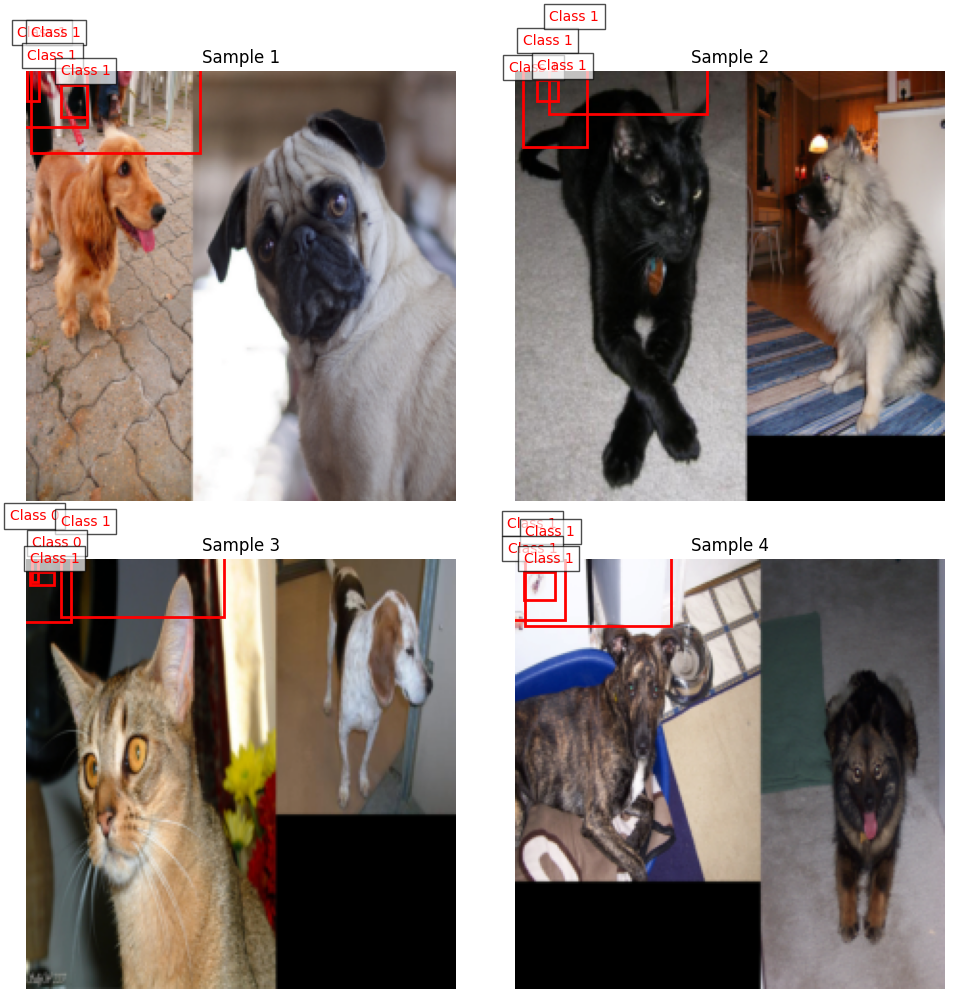

 
| End of Epoch 1 | Time Taken: 50.64s | Train Accuracy: 0.7988 | Train Loss: 1.2053 | Val Loss: 0.9804 | mAP: 0.0000
Ending Epoch 1...

-----------------------------------------------------------
Starting Epoch 2....

| Epoch 2 | 100/369 Batches | Loss: 0.6359837055206299
| Epoch 2 | 200/369 Batches | Loss: 0.6834110617637634
| Epoch 2 | 300/369 Batches | Loss: 0.4482197165489197
 


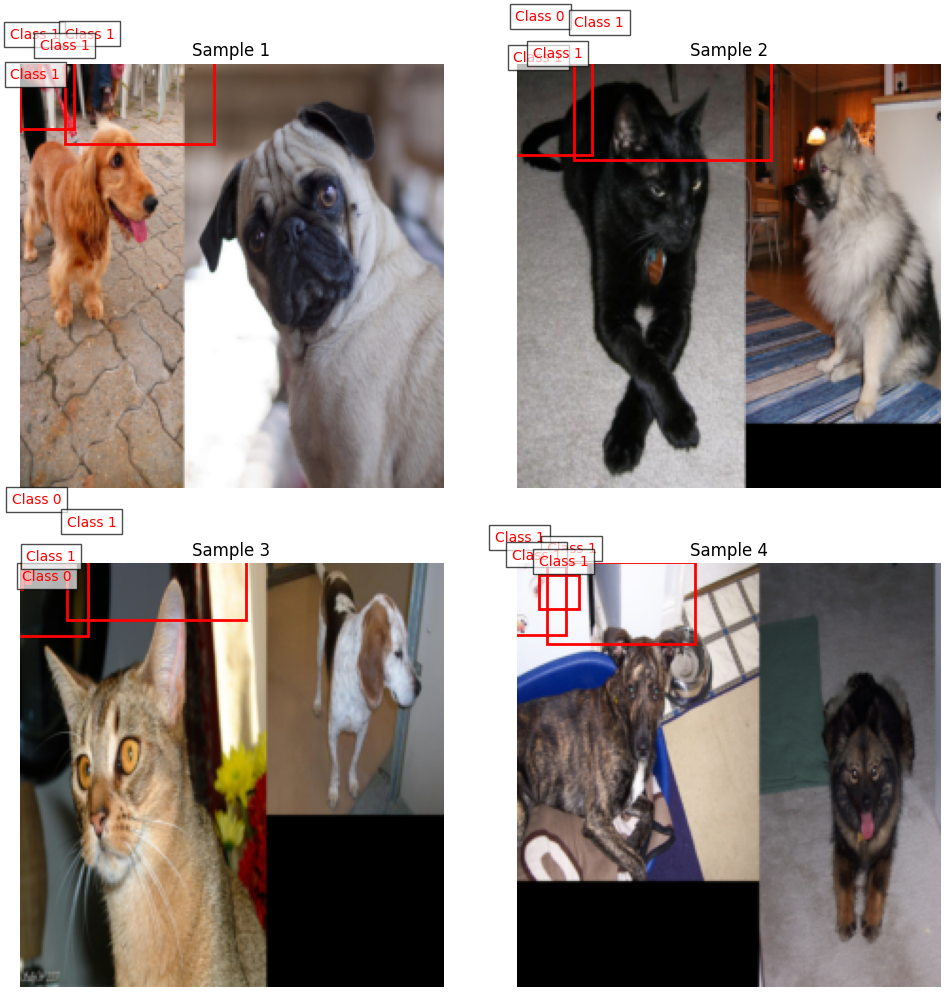

 
| End of Epoch 2 | Time Taken: 50.38s | Train Accuracy: 0.9057 | Train Loss: 0.7931 | Val Loss: 0.7205 | mAP: 0.0001
Ending Epoch 2...

-----------------------------------------------------------
Starting Epoch 3....

| Epoch 3 | 100/369 Batches | Loss: 0.5258045196533203
| Epoch 3 | 200/369 Batches | Loss: 0.5570686459541321
| Epoch 3 | 300/369 Batches | Loss: 0.3738973140716553
| End of Epoch 3 | Time Taken: 51.43s | Train Accuracy: 0.9376 | Train Loss: 0.6311 | Val Loss: 0.4924 | mAP: 0.0000
Ending Epoch 3...

-----------------------------------------------------------
Starting Epoch 4....

| Epoch 4 | 100/369 Batches | Loss: 0.33489686250686646
| Epoch 4 | 200/369 Batches | Loss: 0.54240483045578
| Epoch 4 | 300/369 Batches | Loss: 0.5558578372001648
| End of Epoch 4 | Time Taken: 50.92s | Train Accuracy: 0.9542 | Train Loss: 0.5562 | Val Loss: 0.5570 | mAP: 0.0000
Ending Epoch 4...

-----------------------------------------------------------
Starting Epoch 5....

| Epoch 5 | 100

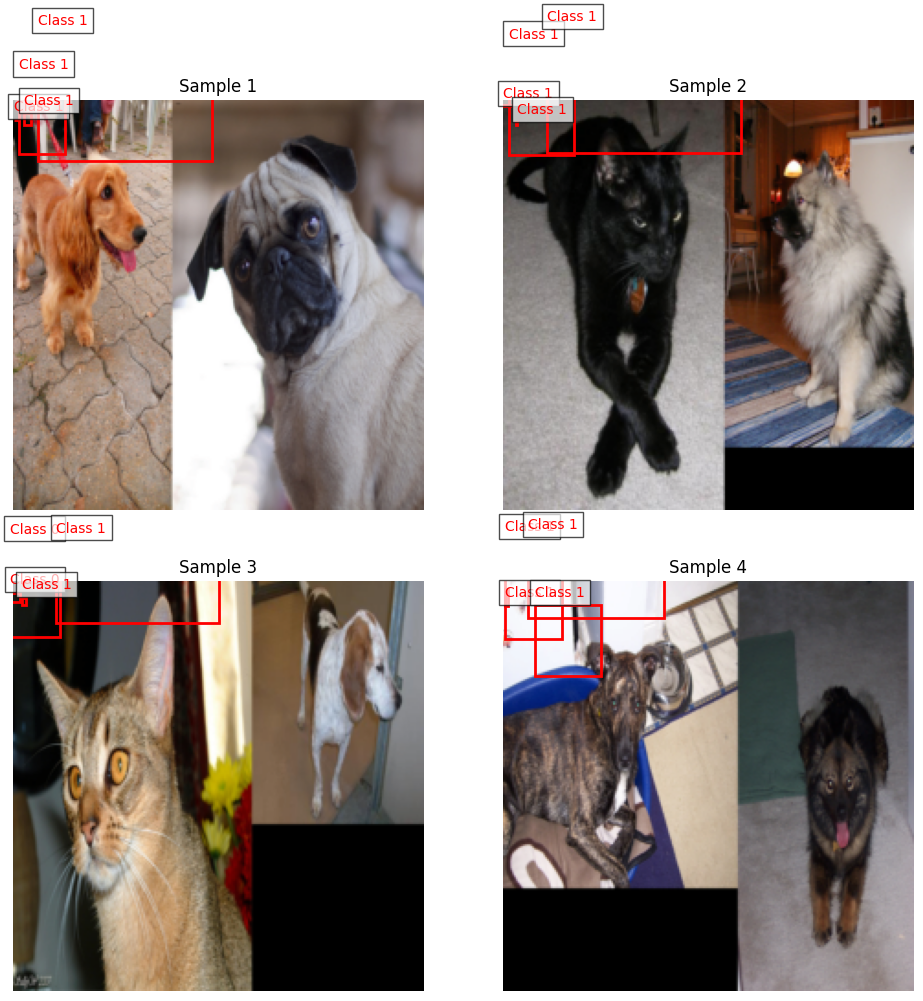

 
| End of Epoch 5 | Time Taken: 52.01s | Train Accuracy: 0.9664 | Train Loss: 0.4895 | Val Loss: 0.5423 | mAP: 0.0001
Ending Epoch 5...

-----------------------------------------------------------
Starting Epoch 6....

| Epoch 6 | 100/369 Batches | Loss: 1.4489550590515137
| Epoch 6 | 200/369 Batches | Loss: 0.4271690845489502
| Epoch 6 | 300/369 Batches | Loss: 0.4508817195892334
| End of Epoch 6 | Time Taken: 50.88s | Train Accuracy: 0.9662 | Train Loss: 0.4897 | Val Loss: 0.5354 | mAP: 0.0001
Ending Epoch 6...

-----------------------------------------------------------
Starting Epoch 7....

| Epoch 7 | 100/369 Batches | Loss: 0.6590955257415771
| Epoch 7 | 200/369 Batches | Loss: 0.3628760278224945
| Epoch 7 | 300/369 Batches | Loss: 0.4650769829750061
| End of Epoch 7 | Time Taken: 51.10s | Train Accuracy: 0.9785 | Train Loss: 0.4170 | Val Loss: 0.5928 | mAP: 0.0000
Ending Epoch 7...

-----------------------------------------------------------
Starting Epoch 8....

| Epoch 8 | 10

<ipython-input-21-ec66e98c61ca>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


In [22]:
epochs = 10
save_model = './SimpleYOLO'
os.makedirs(save_model, exist_ok = True)

SimpleYOLO, metrics = train(
    model, 'SimpleYOLO', save_model, optim, train_loader, val_loader, epochs, device
)

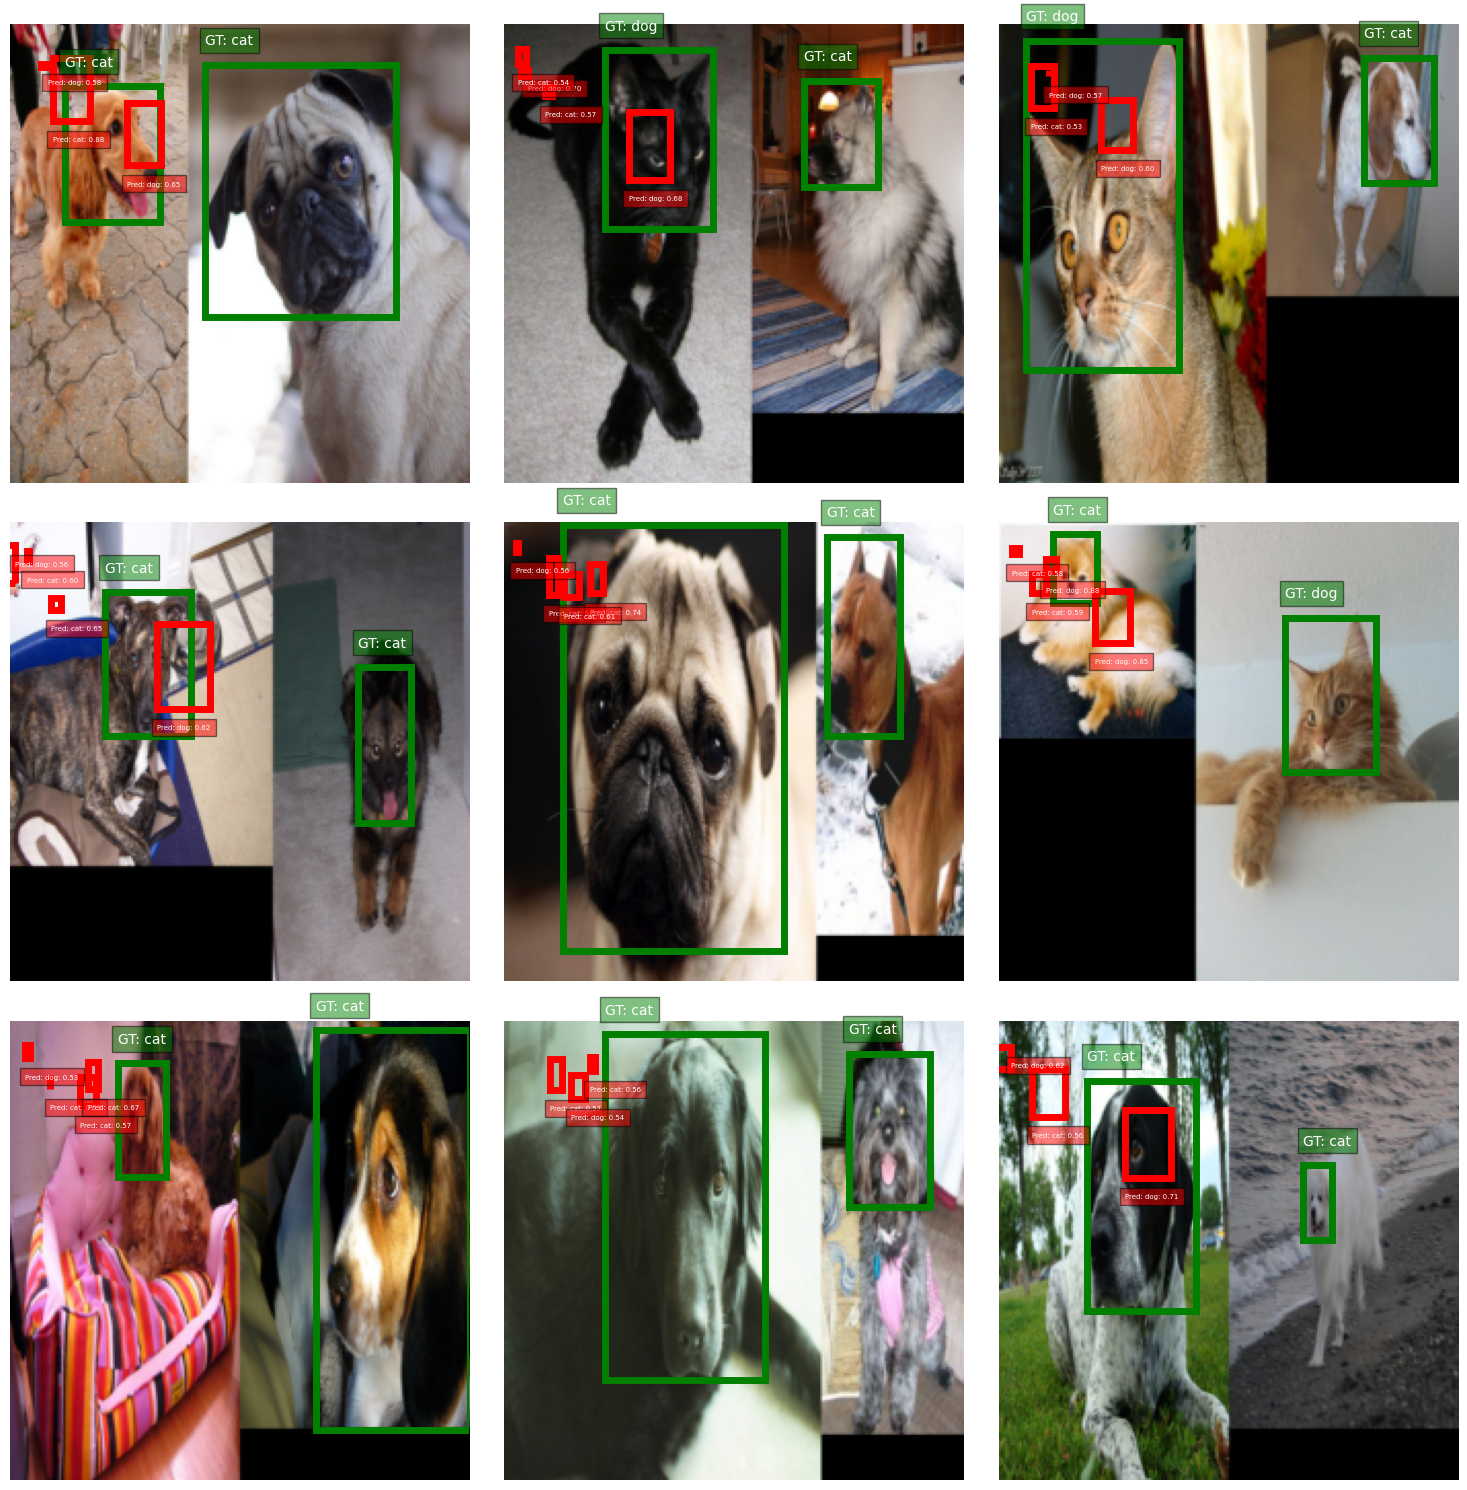

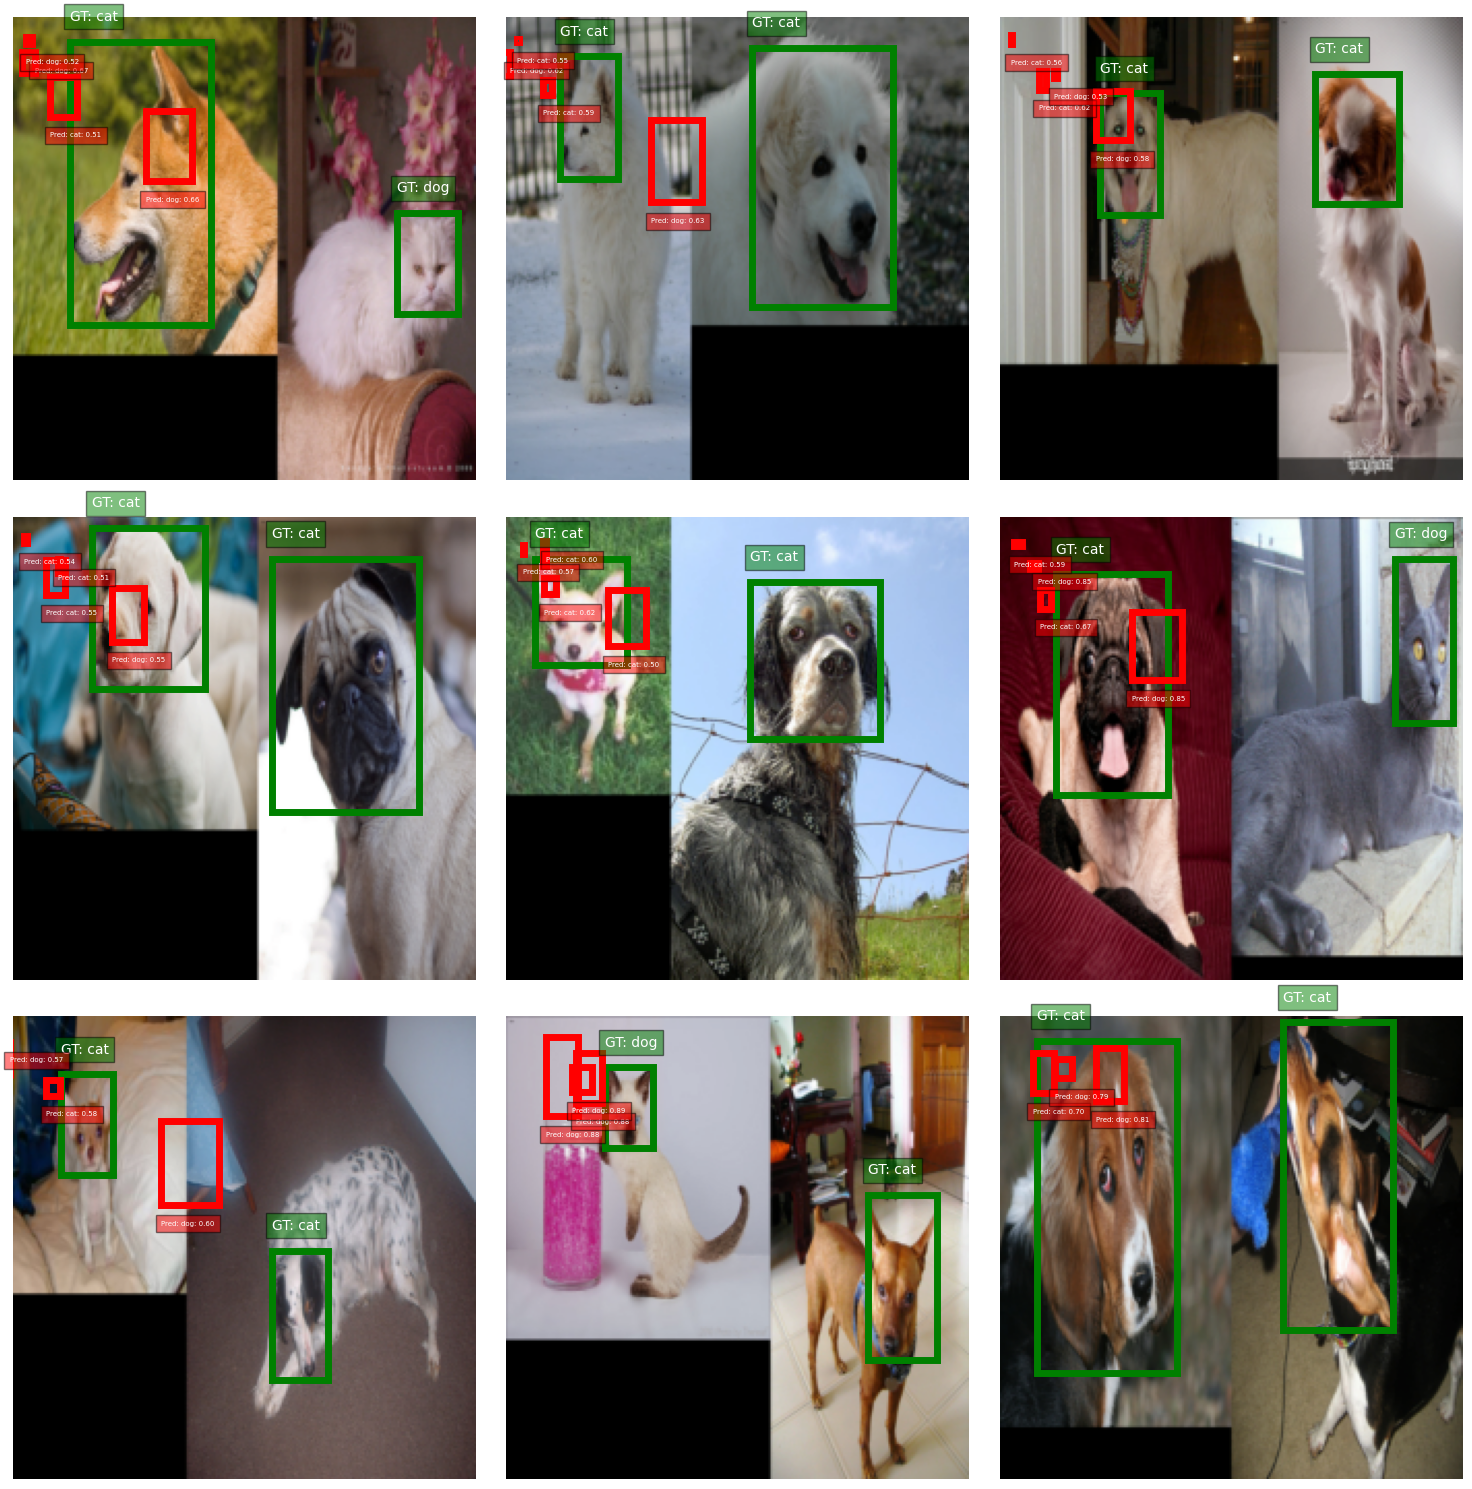

In [23]:
def visualize_predictions(val_dataset, model, device, class_to_idx, num_rows=3, num_cols=3, start_idx=0):
    """
    Visualize model predictions vs ground truth on validation dataset
    
    Args:
        val_dataset: Validation dataset
        model: Trained model
        device: Device to run model on
        class_to_idx: Dictionary mapping class names to indices
        num_rows: Number of rows in grid
        num_cols: Number of columns in grid
        start_idx: Starting index in validation dataset
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        # Get image and annotations from validation dataset
        image_tensor, annotations = val_dataset[start_idx + idx]
        
        # Denormalize the image
        denorm = transforms.Compose([
            transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            )
        ])
        image_tensor = denorm(image_tensor)
        image_tensor = torch.clamp(image_tensor, 0, 1)
        
        # Convert tensor to PIL Image for display
        image = transforms.ToPILImage()(image_tensor)
        width, height = image.size

        # Get model predictions
        model.eval()
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0).to(device))
            output = output.view(1, 2, 2, 4 + len(class_to_idx))

        ax.axis("off")
        ax.imshow(image)

        # Draw ground truth boxes (in green)
        for ann in annotations:
            bbox = ann[:4]
            label = int(ann[4].item())
            name = list(class_to_idx.keys())[label]

            # Scale bounding box coordinates to image size
            xmin = bbox[0] * width
            ymin = bbox[1] * height
            xmax = bbox[2] * width
            ymax = bbox[3] * height

            # Draw ground truth box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=5,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                xmin,
                ymin - 10,  # Slightly above the box
                f"GT: {name}",
                color="white",
                fontsize=10,
                bbox=dict(facecolor="green", alpha=0.5),
            )

        # Draw predicted boxes (in red)
        for grid_y in range(2):
            for grid_x in range(2):
                class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
                bbox = output[0, grid_y, grid_x, :4].tolist()

                if torch.all(torch.round(torch.tensor(bbox), decimals=1) == 0):
                    continue

                confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[
                    class_pred
                ].item()

                x_min = bbox[0] * width
                y_min = bbox[1] * height
                x_max = bbox[2] * width
                y_max = bbox[3] * height

                if confidence > 0.5:
                    rect = patches.Rectangle(
                        (x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth=5,
                        edgecolor="r",
                        facecolor="none",
                    )
                    ax.add_patch(rect)
                    ax.text(
                        x_min,
                        y_max + 10,  # Slightly below the box
                        f"Pred: {list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",
                        color="white",
                        fontsize=5,
                        bbox=dict(facecolor="red", alpha=0.5),
                    )

    plt.tight_layout()
    plt.show()

# Plot first grid (images 0-8)
visualize_predictions(val_set, model, device, class_2_idx, start_idx=0)

# Plot second grid (images 9-17)
visualize_predictions(val_set, model, device, class_2_idx, start_idx=9)

# I fucked up somewhere, It CANNOT possibly perform THIS BAD